In [1]:
import numpy as np
import time
import matplotlib.pyplot as plt

In [2]:
def prim(graph):
    n = np.shape(graph)[0]
    nearest = np.zeros(n, dtype=np.int64)
    distances = graph[0, :].copy() if graph.dtype.kind != 'u' else graph[0, :].copy().astype(np.int64)
    min_span_tree = np.zeros((n, n), dtype=graph.dtype)
    min_total_weight = 0

    for _ in range(n - 1):
        min_ = np.Inf
        v_near = -1
        for i in range(1, n):
            if 0 < distances[i] < min_:
                min_ = distances[i]
                v_near = i
        min_span_tree[v_near, nearest[v_near]] = graph[v_near, nearest[v_near]]
        min_span_tree[nearest[v_near], v_near] = graph[nearest[v_near], v_near]
        min_total_weight += graph[nearest[v_near], v_near]

        distances[v_near] = -1
        for i in range(1, n):
            if graph[i, v_near] and graph[i, v_near] < distances[i] or distances[i] == 0:
                distances[i] = graph[i, v_near]
                nearest[i] = v_near
    return min_span_tree, min_total_weight

In [3]:
M = np.array([[0, 1, 3, np.inf, np.inf], [1, 0, 3, 6, np.inf], [3, 3, 0, 4, 2], [np.inf, 6, 4, 0, 5], [np.inf, np.inf, 2, 5, 0]])
M

array([[ 0.,  1.,  3., inf, inf],
       [ 1.,  0.,  3.,  6., inf],
       [ 3.,  3.,  0.,  4.,  2.],
       [inf,  6.,  4.,  0.,  5.],
       [inf, inf,  2.,  5.,  0.]])

In [4]:
prim(M)

(array([[0., 1., 3., 0., 0.],
        [1., 0., 0., 0., 0.],
        [3., 0., 0., 4., 2.],
        [0., 0., 4., 0., 0.],
        [0., 0., 2., 0., 0.]]),
 10.0)

In [5]:
class UnionFind:
    def __init__(self, n):
        self.parent = np.arange(n)
        self.rank = np.zeros(n, dtype=int)

    def find(self, u):
        if self.parent[u] != u:
            self.parent[u] = self.find(self.parent[u])
        return self.parent[u]

    def union(self, u, v):
        root_u = self.find(u)
        root_v = self.find(v)
        if root_u != root_v:
            if self.rank[root_u] > self.rank[root_v]:
                self.parent[root_v] = root_u
            elif self.rank[root_u] < self.rank[root_v]:
                self.parent[root_u] = root_v
            else:
                self.parent[root_v] = root_u
                self.rank[root_u] += 1

In [6]:
def kruskal(graph):
    n = graph.shape[0]
    edges = []

    # Extract edges from the adjacency matrix
    for i in range(n):
        for j in range(i + 1, n):
            if graph[i, j] != 0:
                edges.append((i, j, graph[i, j]))

    # Sort edges by weight
    edges = sorted(edges, key=lambda x: x[2])
    uf = UnionFind(n)
    mst = []
    mst_weight = 0

    for u, v, weight in edges:
        if uf.find(u) != uf.find(v):
            uf.union(u, v)
            mst.append((u, v, weight))
            mst_weight += weight

    return mst, mst_weight

In [7]:
kruskal(M)

([(0, 1, 1.0), (2, 4, 2.0), (0, 2, 3.0), (2, 3, 4.0)], 10.0)

In [8]:
def random_complete_graph(n: int, item_range=(0, 100)):
    random_matrix = np.random.randint(item_range[0], item_range[1], (n, n), dtype=np.uint8)
    np.fill_diagonal(random_matrix, 0)
    return (random_matrix + random_matrix.T) // 2

In [9]:
def expand_graph(graph: np.ndarray, percent=20):
    n = graph.shape[0]
    span = np.zeros(n ** 2, dtype=graph.dtype)
    random_count = int(n ** 2 * (percent / 100))
    random_indices = np.random.randint(0, span.shape[0], size = random_count)
    random_nums = np.random.randint(1, 100, size = random_count)
    span[random_indices] = random_nums
    new_graph = graph + span.reshape((n, n))
    np.fill_diagonal(new_graph, 0)
    return (new_graph + new_graph.T) / 2

In [10]:
expand_graph(np.array([[0., 1., 3., 0., 0.],
        [1., 0., 0., 0., 0.],
        [3., 0., 0., 4., 2.],
        [0., 0., 4., 0., 0.],
        [0., 0., 2., 0., 0.]]), 0)

array([[0., 1., 3., 0., 0.],
       [1., 0., 0., 0., 0.],
       [3., 0., 0., 4., 2.],
       [0., 0., 4., 0., 0.],
       [0., 0., 2., 0., 0.]])

In [11]:
def draw_chart(x, y, z, title):
    plt.style.use('_mpl-gallery')

    sorted_args = np.argsort(x)
    x = x[sorted_args]
    y = y[sorted_args]
    z = z[sorted_args]

    fig, ax = plt.subplots(figsize=(18, 4))
    
    ax.plot(x, y, linewidth=2.0, color='green', label='Prim Algorithm')
    ax.plot(x, z, linewidth=2.0, color='red', label='Kruskal Algorithm')

    ax.legend()
    plt.title(title)
    plt.xlabel('nodes count')
    plt.ylabel('time (s)')
    
    plt.show()

In [12]:
def benchmark(repetitions_count, matrix_size_range = (100, 1000)):
    prim_elapsed_times = {
        "complete": np.zeros(repetitions_count),
        "0": np.zeros(repetitions_count),
        "10": np.zeros(repetitions_count),
        "20": np.zeros(repetitions_count),
        "35": np.zeros(repetitions_count),
        "50": np.zeros(repetitions_count),
        "75": np.zeros(repetitions_count),
    }
    
    kruskal_elapsed_times = {
        "complete": np.zeros(repetitions_count),
        "0": np.zeros(repetitions_count),
        "10": np.zeros(repetitions_count),
        "20": np.zeros(repetitions_count),
        "35": np.zeros(repetitions_count),
        "50": np.zeros(repetitions_count),
        "75": np.zeros(repetitions_count),
    }
    
    graph_sizes = np.zeros(repetitions_count, dtype=np.int16)
    
    for i in range(repetitions_count):

        # generate random complete graph
        size = np.random.randint(matrix_size_range[0], matrix_size_range[1])
        M = random_complete_graph(size, (1,100))
        graph_sizes[i] = size
    
        # running prim algorithm for complete graph
        start_time = time.time()
        p_tree, p_weight = prim(M)
        end_time = time.time()
        elapsed_time = end_time - start_time
        prim_elapsed_times["complete"][i] = elapsed_time
    
        # running kruskal algorithm for complete graph
        start_time = time.time()
        k_tree, k_weight = kruskal(M)
        end_time = time.time()
        elapsed_time = end_time - start_time
        kruskal_elapsed_times["complete"][i] = elapsed_time

        if (k_weight != p_weight):
            raise(f'Conflict Weight: kruskal = {k_weight}, prim = {p_weight}')
        
        # -------------------------------------------------------------------------------------------------------------------
        
        for j in [0, 10, 20, 35, 50, 75]:
            
            expanded_tree = expand_graph(p_tree, j) if i != 0 else p_tree
            
             # running prim algorithm
            start_time = time.time()
            pl_tree, pl_weight = prim(expanded_tree)
            end_time = time.time()
            elapsed_time = end_time - start_time
            prim_elapsed_times[f'{j}'][i] = elapsed_time
    
            # running kruskal algorithm
            start_time = time.time()
            kl_tree, kl_weight = kruskal(expanded_tree)
            end_time = time.time()
            elapsed_time = end_time - start_time
            kruskal_elapsed_times[f'{j}'][i] = elapsed_time
    
            if (kl_weight != pl_weight):
                raise(f'Conflict Weight: kruskal = {kl_weight}, prim = {pl_weight}')
                
        print(f'step {i + 1} done, nodes count: {size}')

    return graph_sizes, prim_elapsed_times, kruskal_elapsed_times

In [13]:
nodes_count, prim_times, kruskal_times = benchmark(100, (100, 500))

step 1 done, nodes count: 201
step 2 done, nodes count: 454
step 3 done, nodes count: 175
step 4 done, nodes count: 159
step 5 done, nodes count: 478
step 6 done, nodes count: 422
step 7 done, nodes count: 441
step 8 done, nodes count: 298
step 9 done, nodes count: 144
step 10 done, nodes count: 373
step 11 done, nodes count: 326
step 12 done, nodes count: 494
step 13 done, nodes count: 195
step 14 done, nodes count: 225
step 15 done, nodes count: 218
step 16 done, nodes count: 227
step 17 done, nodes count: 409
step 18 done, nodes count: 156
step 19 done, nodes count: 327
step 20 done, nodes count: 172
step 21 done, nodes count: 145
step 22 done, nodes count: 205
step 23 done, nodes count: 264
step 24 done, nodes count: 240
step 25 done, nodes count: 135
step 26 done, nodes count: 237
step 27 done, nodes count: 417
step 28 done, nodes count: 116
step 29 done, nodes count: 273
step 30 done, nodes count: 182
step 31 done, nodes count: 137
step 32 done, nodes count: 344
step 33 done, nod

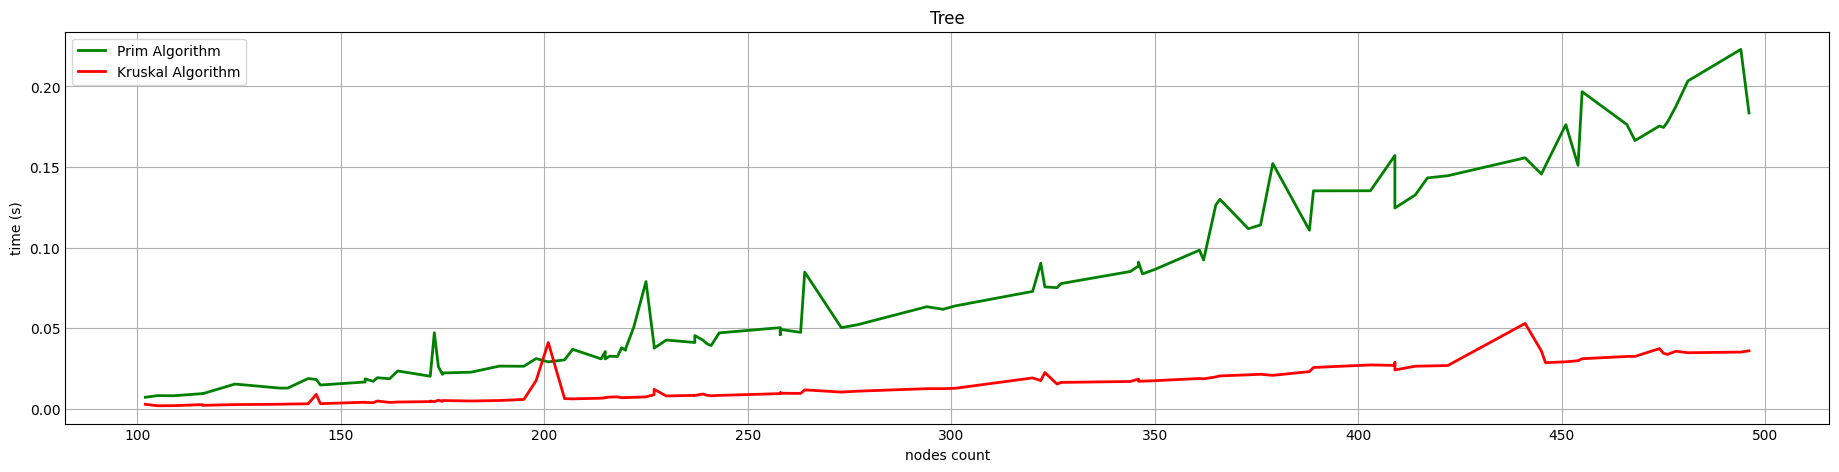

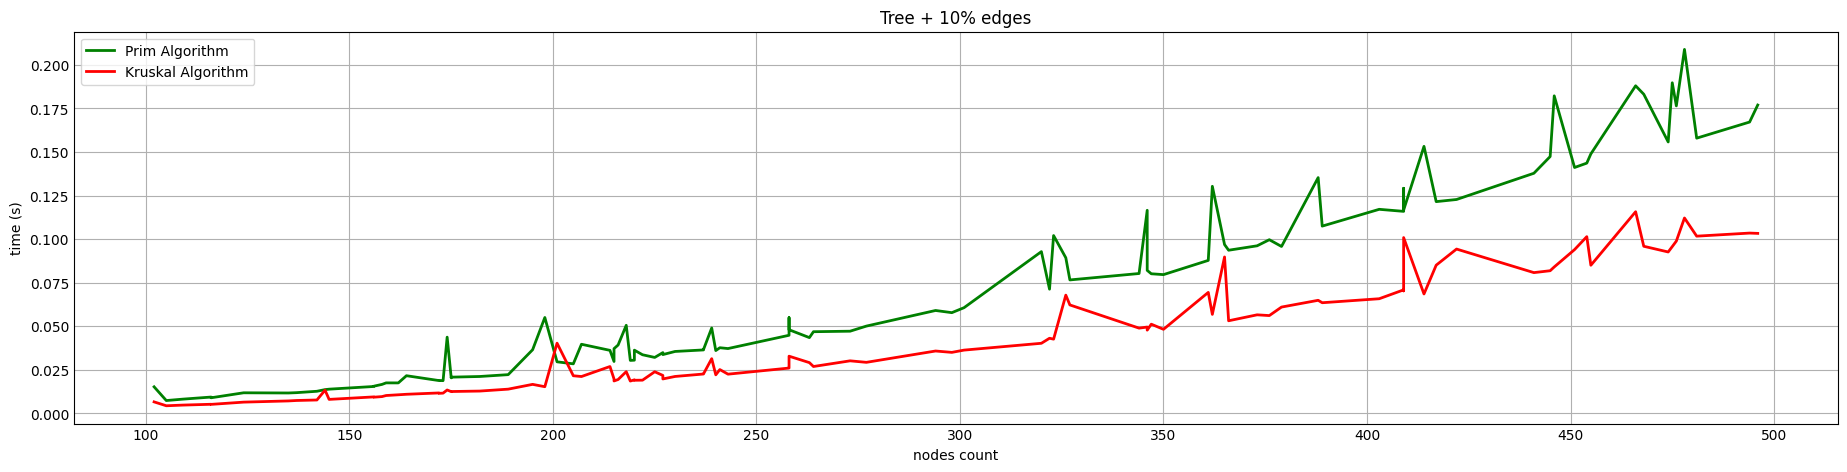

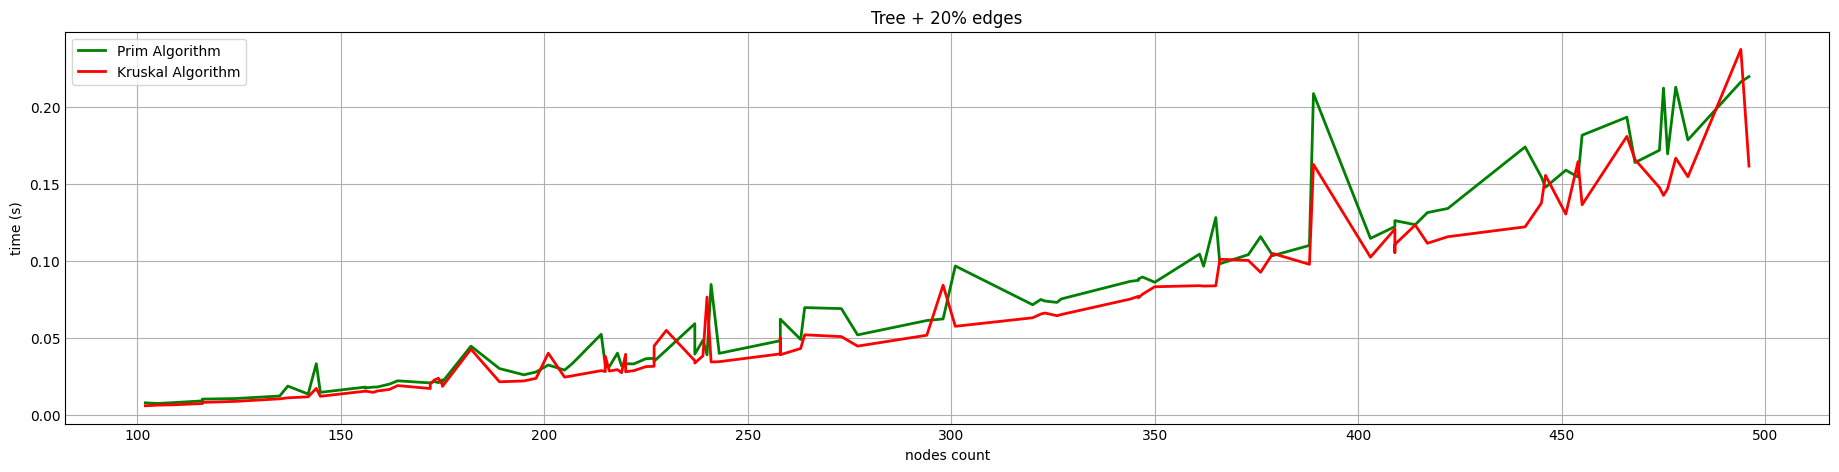

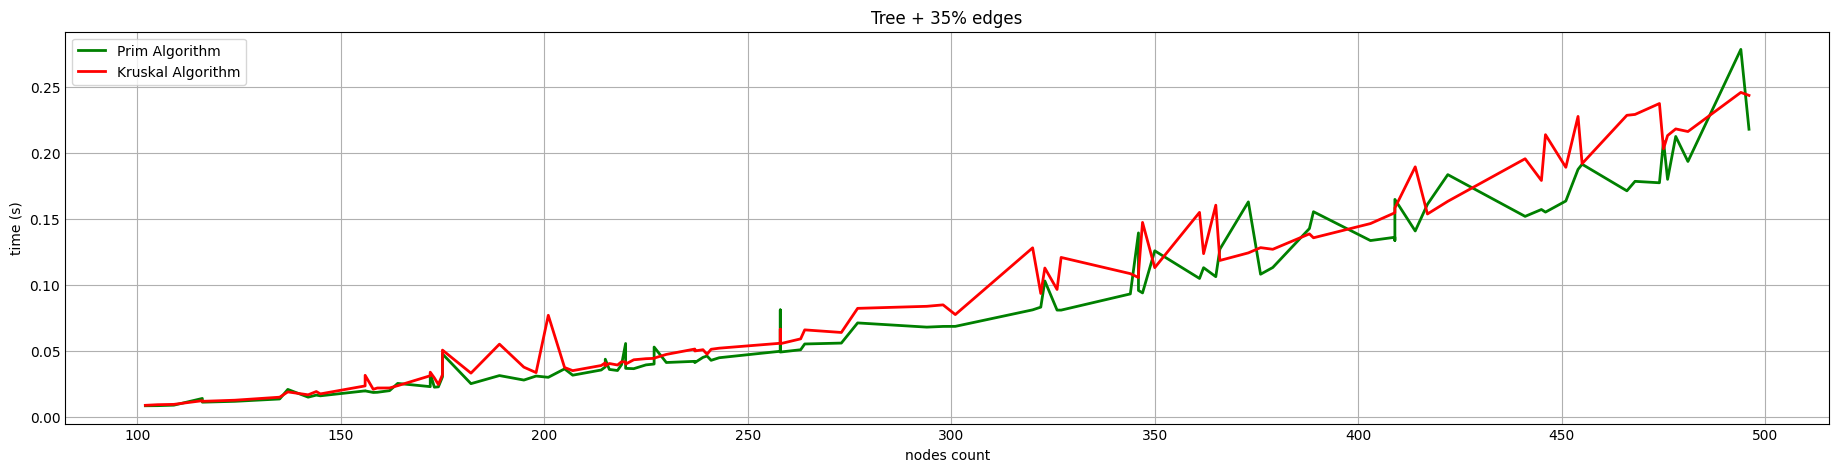

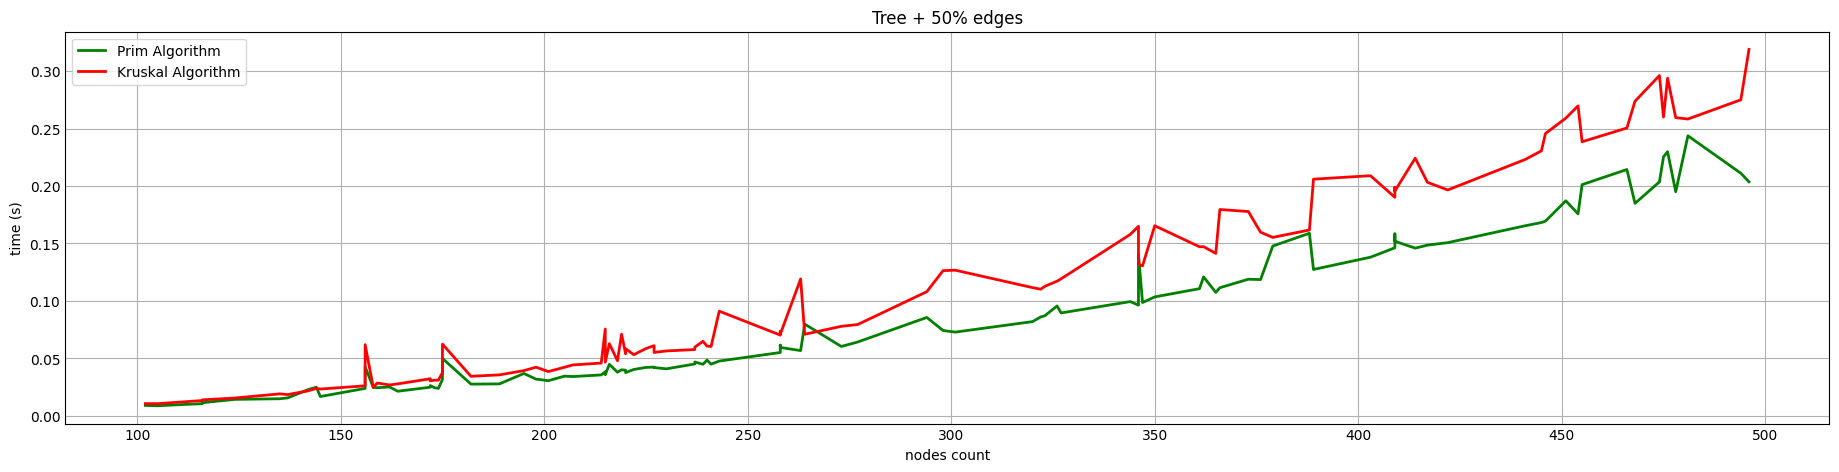

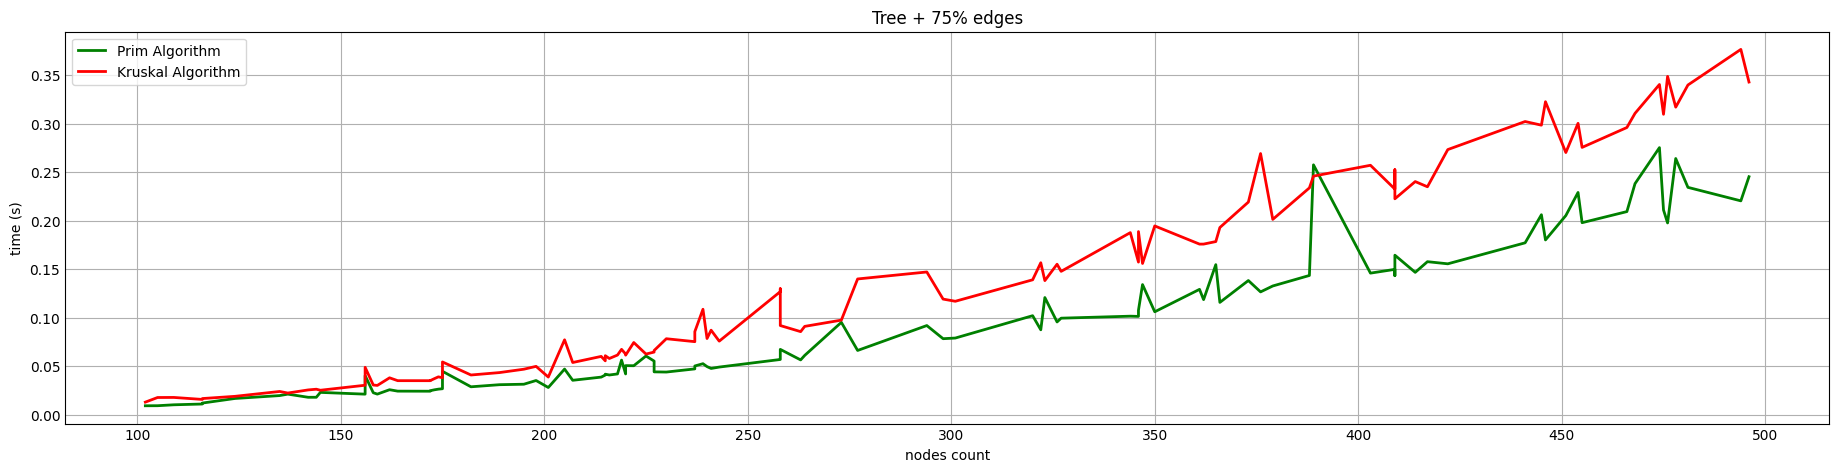

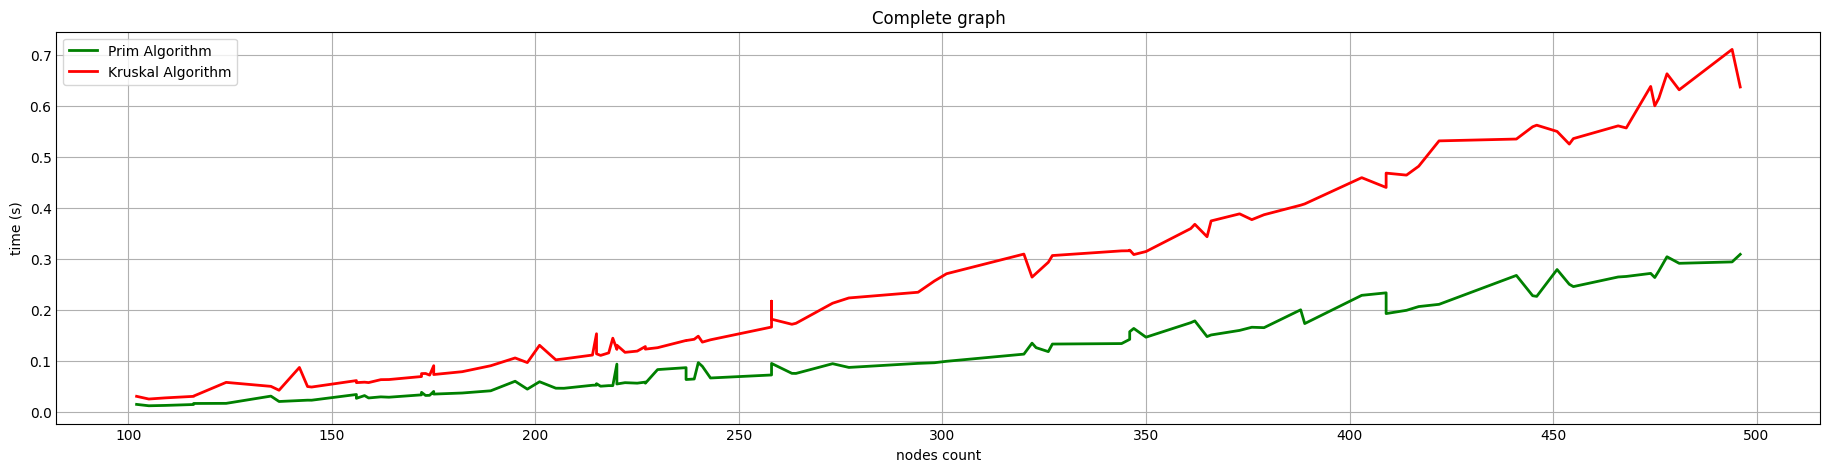

In [14]:
for i in [0, 10, 20, 35, 50, 75]:
    draw_chart(nodes_count, prim_times[f'{i}'], kruskal_times[f'{i}'], 'Tree' if i == 0 else f'Tree + {i}% edges')
draw_chart(nodes_count, prim_times["complete"], kruskal_times["complete"], "Complete graph")